In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import tmm
import matplotlib.pyplot as plt
from typing import Tuple, List

import sys; sys.path.append('../../../tidy3d')
import tidy3d as td
from tidy3d.web import run as run_sim
from tidy3d.plugins.adjoint import JaxSimulation, JaxBox, JaxMedium, JaxStructure, JaxSimulationData
from tidy3d.plugins.adjoint.web import run as run_adjoint

INFO:rich:Using client version: 1.8.0


In [2]:
freq0 = 2e14
freqs = [freq0]
wavelength = td.C_0 / freq0
bck_eps = 1.4**2

eps0 = [2.**2, 1.8**2, 1.5**2, 1.9**2]
ds0 = [0.5, 0.25, 0.5, 0.25]


def ds_to_tops(ds):
    slab_tops = []
    z_bottom = -np.sum(ds) / 2.
    for d in ds:
        z_top = z_bottom + d
        slab_tops.append(z_top)
        z_bottom = z_top
    return slab_tops

def tops_to_ds(tops):
    z_bottom = -tops[-1]
    d_bottom = tops[0] - z_bottom
    ds = [d_bottom]
    for i in range(len(tops)-1):
        ds.append(tops[i+1] - tops[i])
    return ds

tops0 = ds_to_tops(ds0)
print(tops0)
print(tops_to_ds(tops0))

theta = 0
dl = 0.0125

[-0.25, 0.0, 0.5, 0.75]
[0.5, 0.25, 0.5, 0.25]


In [3]:
def normalize(arr):
    return arr / np.linalg.norm(arr)

def compute_error(truth, guess):
    return np.linalg.norm(truth - guess) / np.linalg.norm(truth)

## TMM / Numerical Gradient

In [4]:
def compute_T_tmm(slab_eps=eps0, slab_tops=tops0) -> float:
    slab_eps = list(slab_eps)
    slab_ds = list(tops_to_ds(slab_tops))
    
    eps_list = [bck_eps] + slab_eps + [bck_eps]
    n_list = np.sqrt(eps_list)    
    d_list = [np.inf] + slab_ds + [np.inf]
    return tmm.coh_tmm("p", n_list, d_list, theta, wavelength)["T"]

In [5]:
T_tmm = compute_T_tmm(slab_eps=eps0, slab_tops=tops0)
print(f"T (tmm) = {T_tmm:.3f}")

T (tmm) = 0.875


In [6]:
def val_and_grad_tmm():

    T0 = compute_T_tmm(eps0, tops0)

    num_slabs = len(eps0)
    grad_tmm = np.zeros((2, num_slabs), dtype=float)
    args = np.stack((eps0, tops0), axis=0)
    delta = 1e-6

    for arg_index in range(2):
        for slab_index in range(num_slabs):
            grad = 0.0
            for pm in (-1, +1):
                args_num = args.copy()
                args_num[arg_index][slab_index] += delta * pm
                T_tmm = compute_T_tmm(args_num[0], args_num[1])
                grad += pm * T_tmm / 2 / delta        
            grad_tmm[arg_index][slab_index] = grad

    grad_eps, grad_top = grad_tmm

    grad_eps = normalize(grad_eps)
    grad_top = normalize(grad_top)
    
    return T0, (grad_eps, grad_top)

In [7]:
T_tmm, (grad_eps_tmm, grad_top_tmm) = val_and_grad_tmm()
print(f"T (tmm)  = {T_tmm}")
print(f"grad_eps (tmm)  = {grad_eps_tmm}")
print(f"grad_top (tmm)  = {grad_top_tmm}")

T (tmm)  = 0.8752655778361093
grad_eps (tmm)  = [-0.47604842  0.72026671  0.08335161 -0.49764072]
grad_top (tmm)  = [-0.4387459   0.37791092 -0.5143388   0.63256697]


## FDTD / Adjoint

In [8]:
def make_sim(slab_eps=eps0, slab_tops=tops0) -> JaxSimulation:

    # frequency setup
    wavelength = td.C_0 / freq0
    fwidth = freq0 / 10.0
    freqs = [freq0]

    # geometry setup
    bck_medium = td.Medium(permittivity=bck_eps)

    space_above = 2
    space_below = 2

    length_x = 0.5
    length_y = 0.5
    length_z = space_below + sum(ds0) + space_above
    sim_size = (length_x, length_y, length_z)

    # make structures
    slabs = []
    slab_ds = tops_to_ds(slab_tops)
    z_start = -slab_tops[-1]
    for (d, eps) in zip(slab_ds, slab_eps):
        slab = JaxStructure(
            geometry=JaxBox(
                center=[0, 0, z_start + d / 2],
                size=[td.inf, td.inf, d]
            ),
            medium=JaxMedium(permittivity=eps),
        )
        slabs.append(slab)
        z_start += d

    # source setup
    gaussian = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
    src_z = -length_z / 2 + 3 * space_below / 4

    source = td.PlaneWave(
        center=(0, 0, src_z),
        size=(td.inf, td.inf, 0),
        source_time=gaussian,
        direction="+",
        angle_theta=theta,
        angle_phi=0,
        pol_angle=0,
    )

    # boundaries
    boundary_x = td.Boundary.bloch_from_source(
        source=source, domain_size=sim_size[0], axis=0, medium=bck_medium
    )
    boundary_spec = td.BoundarySpec(x=boundary_x, y=td.Boundary.periodic(), z=td.Boundary.pml(num_layers=40))

    # monitors
    mnt_z = length_z / 2 - wavelength
    monitor_1 = td.DiffractionMonitor(
        center=[0.0, 0.0, mnt_z],
        size=[td.inf, td.inf, 0],
        freqs=freqs,
        name="diffraction",
        normal_dir="+",
    )

    # make simulation
    return JaxSimulation(
        size=sim_size,
        grid_spec=td.GridSpec.uniform(dl=dl),
        input_structures=slabs,
        sources=[source],
        output_monitors=[monitor_1],
        run_time=50 / fwidth,
        boundary_spec=boundary_spec,
        medium=bck_medium,
        subpixel=True,
        shutoff=1e-8,
    )

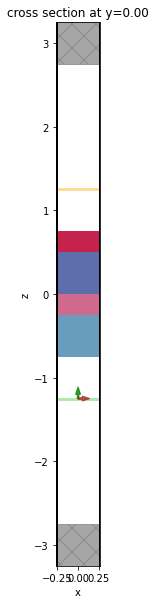

In [9]:
sim = make_sim()
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sim.plot(y=0, ax=ax)
plt.show()

In [10]:
def post_process_T(sim_data: JaxSimulationData) -> float:
    amps = sim_data.output_monitor_data["diffraction"].amps.sel(polarization="p")
    return jnp.sum(abs(amps.values)**2)

def compute_T_fdtd(slab_eps=eps0, slab_tops=tops0) -> float:
    sim = make_sim(slab_eps=slab_eps, slab_tops=slab_tops)
    sim_data = run_adjoint(sim, task_name='slab')
    return post_process_T(sim_data)

compute_T_and_grad_fdtd = jax.value_and_grad(compute_T_fdtd, argnums=(0, 1))

In [11]:
T_fdtd, (grad_eps_fdtd, grad_top_fdtd) = compute_T_and_grad_fdtd(eps0, tops0)

↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0% • 12.1/12.1 MB • 2.9 MB/s • 0:00:00

INFO:rich:loading SimulationData from simulation_data.hdf5


In [12]:
print(f"T (tmm)  = {T_tmm:.3f}")
print(f"T (FDTD) = {T_fdtd:.3f}")

T (tmm)  = 0.875
T (FDTD) = 0.876


In [13]:
grad_eps_tmm = normalize(grad_eps_tmm)
grad_eps_fdtd = normalize(grad_eps_fdtd)
grad_top_tmm = normalize(grad_top_tmm)
grad_top_fdtd = normalize(grad_top_fdtd)

error_T = compute_error(T_tmm, T_fdtd)
error_eps = compute_error(grad_eps_tmm, grad_eps_fdtd)
error_top = compute_error(grad_top_tmm, grad_top_fdtd)

In [14]:
print('\ntransmission:\n')
print(T_tmm)
print(T_fdtd)
print(f'error = {(error_T*100):.4f}%')
print('\ngradient EPSILON:\n')
print(grad_eps_tmm)
print(grad_eps_fdtd)
print(f'error = {(error_eps*100):.4f}%')
print('\ngradient TOP:\n')
print(grad_top_tmm)
print(grad_top_fdtd)
print(f'error = {(error_top*100):.4f}%')


transmission:

0.8752655778361093
0.8756735
error = 0.0466%

gradient EPSILON:

[-0.47604842  0.72026671  0.08335161 -0.49764072]
[-0.4724427   0.7229099   0.08918309 -0.49623132]
error = 0.7482%

gradient TOP:

[-0.4387459   0.37791092 -0.5143388   0.63256697]
[-0.5228621   0.4513099  -0.61241204  0.38455978]
error = 28.9117%
